### import Library and Data

In [1]:
import FinancialMachineLearning as fml
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./Data/kosdaq_sample_2020.csv', index_col = 0)
df = fml.getDataFrame(df)
mad = fml.madOutlier(df.price.values.reshape(-1, 1))
df = df.loc[~mad]
df

1175.8
[141.9 142.1 141.9 ... 351.9 351.9 349.2]
[0.59264118 0.59347647 0.59264118 ... 1.4697     1.4697     1.45842353]


,price,buy,sell,volume,v,dv
2020-01-02 10:00:00.000000,1033.9,67.0,0.0,67.0,67.0,69271.3
2020-01-02 10:00:00.164367,1033.7,2.0,0.0,2.0,2.0,2067.4
2020-01-02 10:00:00.328734,1033.9,0.0,3.0,3.0,3.0,3101.7
2020-01-02 10:00:00.493101,1034.0,11.0,0.0,11.0,11.0,11374.0
2020-01-02 10:00:00.657468,1034.1,0.0,1.0,1.0,1.0,1034.1
...,...,...,...,...,...,...
2020-12-30 15:34:58.296057,1527.8,1.0,0.0,1.0,1.0,1527.8
2020-12-30 15:34:58.862038,1527.8,23.0,0.0,23.0,23.0,35139.4
2020-12-30 15:34:59.428019,1527.7,0.0,1.0,1.0,1.0,1527.7
2020-12-30 15:34:59.994000,1527.7,0.0,1.0,1.0,1.0,1527.7


Dollar Bar Sampling

In [3]:
dollar_M = 1000000
dollar_df = fml.BarSampling(df, 'dv', dollar_M)
dollar_df = dollar_df.groupby(level = 0).first()
dollar_df

,price,buy,sell,volume,v,dv
2020-01-02 10:00:56.049189,1033.1,5.0,0.0,5.0,5.0,5165.5
2020-01-02 10:02:40.685586,1030.6,0.0,13.0,13.0,13.0,13397.8
2020-01-02 10:05:28.764247,1026.2,5.0,0.0,5.0,5.0,5131.0
2020-01-02 10:07:03.488023,1024.8,22.0,0.0,22.0,22.0,22545.6
2020-01-02 10:07:53.541157,1024.2,1.0,0.0,1.0,1.0,1024.2
...,...,...,...,...,...,...
2020-12-30 15:29:36.871312,1525.5,11.0,0.0,11.0,11.0,16780.5
2020-12-30 15:30:48.056418,1525.8,0.0,16.0,16.0,16.0,24412.8
2020-12-30 15:32:02.448735,1527.3,2.0,0.0,2.0,2.0,3054.6
2020-12-30 15:33:33.050587,1527.3,3.0,0.0,3.0,3.0,4581.9


Fractionally Differencing

In [4]:
import statsmodels.api as sm

cols = ['adfStat','pVal','lags','nObs','95% conf', 'corr']
out = pd.DataFrame(columns = cols)
for d in np.linspace(0, 2, 21):
    try:
        df1 = np.log(dollar_df).resample('1H').last().dropna() # daily return
        df2 = fml.fracDiff(df1, d, thres = 1e-5)
        corr = np.corrcoef(df1.loc[df2.index, 'price'], df2['price'])[0,1]
        df2 = sm.tsa.stattools.adfuller(df2['price'], maxlag = 1, regression = 'c', autolag = None)
        out.loc[d] = list(df2[:4]) + [df2[4]['5%']] + [corr]
    except Exception as e:
        print(f'd: {d.round(1)}, error: {e}')
        continue

d: 0.1, error: zero-size array to reduction operation maximum which has no identity
d: 0.2, error: zero-size array to reduction operation maximum which has no identity
d: 0.3, error: Invalid input, x is constant
d: 0.4, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.5, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors


,adfStat,pVal,lags,nObs,95% conf,corr
0.0,-0.316168,9.231830e-01,1.0,1731.0,-2.863211,1.000000
0.6,-2.451591,1.277013e-01,1.0,9.0,-3.289881,0.090000
0.7,-2.956039,3.920880e-02,1.0,25.0,-2.986489,0.428888
0.8,-5.099136,1.407515e-05,1.0,72.0,-2.902607,0.349921
0.9,-10.815119,1.865700e-19,1.0,256.0,-2.872897,0.105514
1.0,-29.431572,0.000000e+00,1.0,1730.0,-2.863212,0.041350
1.1,-20.778818,0.000000e+00,1.0,744.0,-2.865433,0.053282
1.2,-23.263057,0.000000e+00,1.0,788.0,-2.865215,0.029689
1.3,-28.151706,0.000000e+00,1.0,951.0,-2.864584,0.008428
1.4,-32.393162,0.000000e+00,1.0,1145.0,-2.864068,0.015597


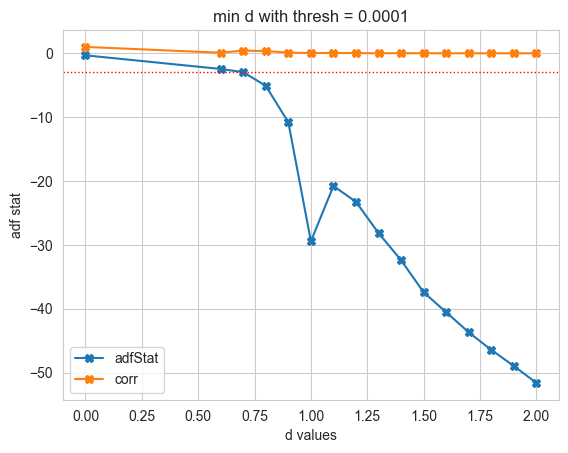

In [5]:
f,ax = plt.subplots()
out[['adfStat', 'corr']].plot(ax = ax, marker = 'X')
ax.axhline(out['95% conf'].mean(), lw = 1, color = 'r', ls = 'dotted')
ax.set_title('min d with thresh = 0.0001')
ax.set_xlabel('d values')
ax.set_ylabel('adf stat')
display(out)

In [6]:
min_ffd = out[out.pVal <= 0.05].iloc[0].name
print("The min. D that makes the fracdiff stationary", min_ffd.round(1))

The min. D that makes the fracdiff stationary 0.7


In [7]:
dfx2 = fml.fracDiff_FFD(dollar_df, min_ffd, thres = 1e-5)
dfx2

,price,buy,sell,volume,v,dv
2020-01-09 14:36:20.594955,7.731653,0.507020,-13.485962,-12.978941,-12.978941,-1.295114e+04
2020-01-09 14:46:00.000000,6.648376,-4.300672,4.067951,-0.232720,-0.232720,-1.755802e+02
2020-01-09 14:57:06.856457,7.123401,-2.312789,-5.513053,-7.825843,-7.825843,-7.806407e+03
2020-01-09 15:01:34.921881,7.165134,8.017902,-2.552537,5.465365,5.465365,5.554189e+03
2020-01-09 15:06:00.799920,6.437717,-7.803489,-1.285490,-9.088979,-9.088979,-9.091834e+03
...,...,...,...,...,...,...
2020-12-30 15:29:36.871312,9.843135,9.081397,-5.009420,4.071977,4.071977,6.235186e+03
2020-12-30 15:30:48.056418,9.029647,-9.292444,14.061818,4.769374,4.769374,7.297076e+03
2020-12-30 15:32:02.448735,10.112257,-0.558077,-12.513802,-13.071879,-13.071879,-1.992667e+04
2020-12-30 15:33:33.050587,8.939422,-0.176230,-2.674972,-2.851203,-2.851203,-4.334281e+03


CUSUM Filtering

In [8]:
threshold = dfx2.std().iat[0] * 2
tEvents = fml.getTEvents(dfx2.price, h = threshold)
tEvents

DatetimeIndex(['2020-01-10 11:15:54.280286', '2020-01-10 14:37:13.669519',
               '2020-01-13 10:21:18.569571', '2020-01-14 10:07:24.543000',
               '2020-01-14 12:45:06.922385', '2020-01-14 13:38:25.132622',
               '2020-01-14 14:15:43.733944', '2020-01-14 15:03:05.454000',
               '2020-01-15 13:20:33.330000', '2020-01-16 09:48:49.495050',
               ...
               '2020-12-28 12:00:32.207305', '2020-12-28 13:47:26.483838',
               '2020-12-28 13:54:22.938882', '2020-12-28 15:32:54.716750',
                      '2020-12-28 15:45:00', '2020-12-29 09:41:48.158449',
               '2020-12-29 09:59:40.765154', '2020-12-30 09:49:47.581448',
               '2020-12-30 10:40:27.689538', '2020-12-30 14:39:51.784295'],
              dtype='datetime64[ns]', length=1698, freq=None)

In [9]:
dollar_feature = dollar_df.price.loc[tEvents]
dollar_feature

2020-01-10 11:15:54.280286    1012.8
2020-01-10 14:37:13.669519    1019.0
2020-01-13 10:21:18.569571    1024.6
2020-01-14 10:07:24.543000    1039.5
2020-01-14 12:45:06.922385    1029.0
                               ...  
2020-12-29 09:41:48.158449    1498.5
2020-12-29 09:59:40.765154    1498.7
2020-12-30 09:49:47.581448    1515.1
2020-12-30 10:40:27.689538    1521.0
2020-12-30 14:39:51.784295    1529.0
Name: price, Length: 1698, dtype: float64

In [10]:
frac_diff_feature = dfx2.loc[tEvents]
frac_diff_feature

,price,buy,sell,volume,v,dv
2020-01-10 11:15:54.280286,2.800825,0.134558,-3.952361,-3.817802,-3.817802,-3843.381940
2020-01-10 14:37:13.669519,8.509246,-3.378867,3.636956,0.258089,0.258089,310.411695
2020-01-13 10:21:18.569571,8.832618,-16.157485,4.715335,-11.442149,-11.442149,-11671.643784
2020-01-14 10:07:24.543000,3.953802,13.294260,-14.008322,-0.714061,-0.714061,-723.650904
2020-01-14 12:45:06.922385,1.986190,-2.908859,-1.866534,-4.775393,-4.775393,-4913.428444
...,...,...,...,...,...,...
2020-12-29 09:41:48.158449,11.454225,1.947285,-1.171122,0.776163,0.776163,1239.007554
2020-12-29 09:59:40.765154,11.655103,-2.942812,-21.208506,-24.151319,-24.151319,-36077.817016
2020-12-30 09:49:47.581448,6.712599,-11.537038,-0.598406,-12.135444,-12.135444,-18430.647109
2020-12-30 10:40:27.689538,12.064350,19.276727,-0.660129,18.616598,18.616598,28343.203947


In [11]:
feature_Mat = (pd.DataFrame().assign(dollar = dollar_feature, frac_diff_dollar = frac_diff_feature.price).drop_duplicates().dropna())
feature_Mat

,dollar,frac_diff_dollar
2020-01-10 11:15:54.280286,1012.8,2.800825
2020-01-10 14:37:13.669519,1019.0,8.509246
2020-01-13 10:21:18.569571,1024.6,8.832618
2020-01-14 10:07:24.543000,1039.5,3.953802
2020-01-14 12:45:06.922385,1029.0,1.986190
...,...,...
2020-12-29 09:41:48.158449,1498.5,11.454225
2020-12-29 09:59:40.765154,1498.7,11.655103
2020-12-30 09:49:47.581448,1515.1,6.712599
2020-12-30 10:40:27.689538,1521.0,12.064350


Volatility

In [12]:
dailyVol = fml.getDailyVolatility(feature_Mat.dollar, span = 50)
dailyVol

2020-01-13 10:21:18.569571         NaN
2020-01-14 10:07:24.543000    0.010339
2020-01-14 12:45:06.922385    0.008824
2020-01-14 13:38:25.132622    0.008447
2020-01-14 14:15:43.733944    0.007364
                                ...   
2020-12-29 09:41:48.158449    0.015328
2020-12-29 09:59:40.765154    0.015440
2020-12-30 09:49:47.581448    0.015363
2020-12-30 10:40:27.689538    0.015412
2020-12-30 14:39:51.784295    0.015680
Name: dailyVol, Length: 1696, dtype: float64

<Axes: >

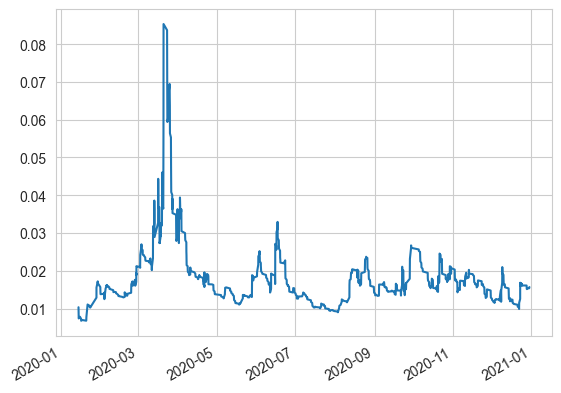

In [13]:
dailyVol.plot()

Vertical Barrier

In [14]:
t1 = fml.addVerticalBarrier(tEvents, feature_Mat.dollar, numDays = 5)
t1

2020-01-10 11:15:54.280286   2020-01-15 13:20:33.330000
2020-01-10 14:37:13.669519   2020-01-16 09:48:49.495050
2020-01-13 10:21:18.569571   2020-01-20 11:08:46.446968
2020-01-14 10:07:24.543000   2020-01-20 11:08:46.446968
2020-01-14 12:45:06.922385   2020-01-20 11:08:46.446968
                                        ...            
2020-12-24 12:08:52.494750   2020-12-30 09:49:47.581448
2020-12-24 13:42:31.720966   2020-12-30 09:49:47.581448
2020-12-24 14:01:25.178829   2020-12-30 09:49:47.581448
2020-12-24 15:10:15.578552   2020-12-30 09:49:47.581448
2020-12-24 15:45:00.000000   2020-12-30 09:49:47.581448
Length: 1685, dtype: datetime64[ns]

In [15]:
import platform
from multiprocessing import cpu_count
if platform.system() == 'Windows':
    cpus = 1
else:
    cpus = cpu_count() - 1
ptsl = [1,1]
target = dailyVol * 2
minRet = 0.001
cpus = cpu_count() - 1
events = fml.getEvents(feature_Mat.dollar, tEvents, ptsl, target, minRet, cpus, t1 = t1)

2023-06-25 03:44:41.887624 100.0% getTripleBarrier done after 0.09 minutes. Remaining 0.0 minutes..


In [16]:
events

,t1,trgt
2020-01-14 10:07:24.543000,2020-01-20 11:08:46.446968,0.020679
2020-01-14 12:45:06.922385,2020-01-20 11:08:46.446968,0.017649
2020-01-14 13:38:25.132622,2020-01-20 11:08:46.446968,0.016894
2020-01-14 14:15:43.733944,2020-01-20 11:08:46.446968,0.014728
2020-01-14 15:03:05.454000,2020-01-20 11:08:46.446968,0.014794
...,...,...
2020-12-29 09:41:48.158449,NaT,0.030657
2020-12-29 09:59:40.765154,NaT,0.030880
2020-12-30 09:49:47.581448,NaT,0.030726
2020-12-30 10:40:27.689538,NaT,0.030825


Concurrent Events

In [17]:
numCoEvents = fml.mpPandasObj(fml.getConcurrentBar, ('molecule', events.index), cpus, closeIdx = feature_Mat.index, t1 = events['t1'])
numCoEvents = numCoEvents.loc[~numCoEvents.index.duplicated(keep = 'last')]
numCoEvents = numCoEvents.reindex(feature_Mat.index).fillna(0)
out = pd.DataFrame()
out['tW'] = fml.mpPandasObj(fml.getAvgLabelUniq, ('molecule', events.index), cpus, t1 = events['t1'], numCoEvents = numCoEvents)
out

2023-06-25 03:44:47.217648 100.0% getConcurrentBar done after 0.07 minutes. Remaining 0.0 minutes..
2023-06-25 03:44:52.013173 100.0% getAvgLabelUniq done after 0.06 minutes. Remaining 0.0 minutes..


,tW
2020-01-14 10:07:24.543000,0.274534
2020-01-14 12:45:06.922385,0.201988
2020-01-14 13:38:25.132622,0.168875
2020-01-14 14:15:43.733944,0.148318
2020-01-14 15:03:05.454000,0.133792
...,...
2020-12-29 09:41:48.158449,0.078333
2020-12-29 09:59:40.765154,0.084028
2020-12-30 09:49:47.581448,0.093519
2020-12-30 10:40:27.689538,0.112500


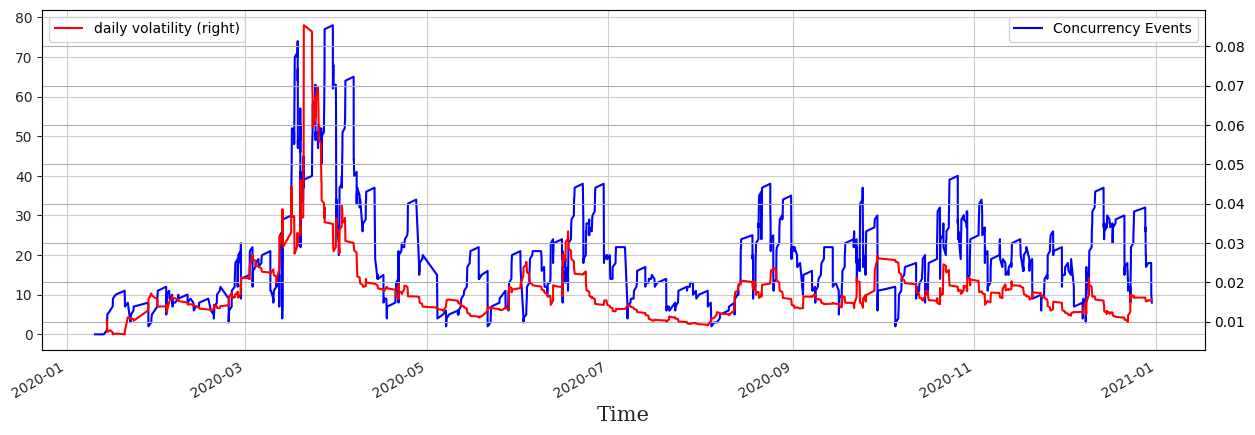

In [18]:
plt.figure(figsize = (15,5))
plt.xlabel('Time', fontfamily = 'Serif', fontsize = 15)

plt.style.use('default')
ax1 = numCoEvents.plot(color = 'blue', grid = True, label = 'Concurrency Events')
ax2 = dailyVol.plot(color = 'red', grid = True, secondary_y = True, label = 'daily volatility')

ax1.legend(loc = 1)
ax2.legend(loc = 2)

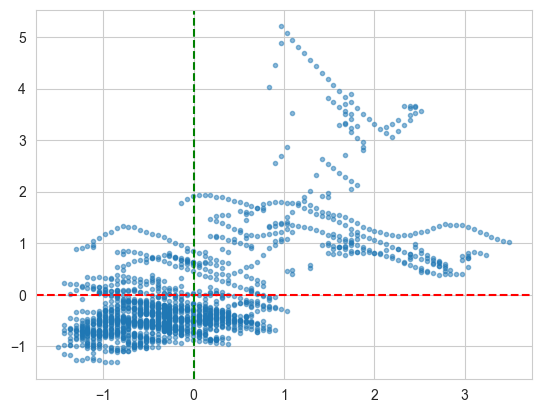

In [19]:
coEvents = numCoEvents.to_frame()
ewmasd = dailyVol.to_frame()
combine = ewmasd.join(coEvents, how = 'inner')
combine.columns = ['ewmasd', 'coEvents']
combine['ewmasd_std'] = (combine['ewmasd']-combine['ewmasd'].mean())/combine['ewmasd'].std()
combine['coEvents_std'] = (combine['coEvents']-combine['coEvents'].mean())/combine['coEvents'].std()

sns.set_style('whitegrid')
plt.scatter(combine['coEvents_std'], combine['ewmasd_std'], marker = '.', alpha = 0.5)
plt.axhline(y = combine['coEvents_std'].mean(), c='r', ls='--')
plt.axvline(x = combine['ewmasd_std'].mean(), c='g', ls='--')
plt.show()

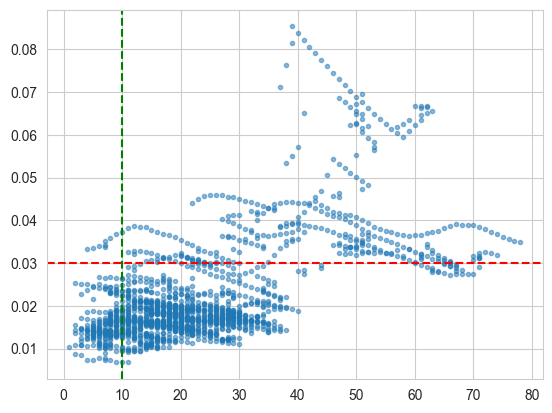

In [20]:
plt.scatter(combine['coEvents'], combine['ewmasd'], marker = '.', alpha = 0.5)
plt.axhline(y = 0.03, c='r', ls='--')
plt.axvline(x = 10, c='g', ls='--')
plt.show()

Weights

In [21]:
out['w'] = fml.mpPandasObj(fml.mpSampleW, ('molecule', events.index),
                           cpus, t1 = events['t1'], numCoEvents = numCoEvents, close = feature_Mat.dollar)
out['w'] *= out.shape[0] / out['w'].sum()
out

2023-06-25 03:44:59.729847 100.0% mpSampleW done after 0.08 minutes. Remaining 0.0 minutes..


,tW,w
2020-01-14 10:07:24.543000,0.274534,6.075020
2020-01-14 12:45:06.922385,0.201988,3.058973
2020-01-14 13:38:25.132622,0.168875,0.152506
2020-01-14 14:15:43.733944,0.148318,0.829902
2020-01-14 15:03:05.454000,0.133792,0.260385
...,...,...
2020-12-29 09:41:48.158449,0.078333,1.437115
2020-12-29 09:59:40.765154,0.084028,1.047958
2020-12-30 09:49:47.581448,0.093519,1.043268
2020-12-30 10:40:27.689538,0.112500,0.660743


1.0 0.0
-0.0998 0.0117
-0.8496 0.0198
-2.1106 0.0332
-2.8596 0.0412
-4.2314 0.0559


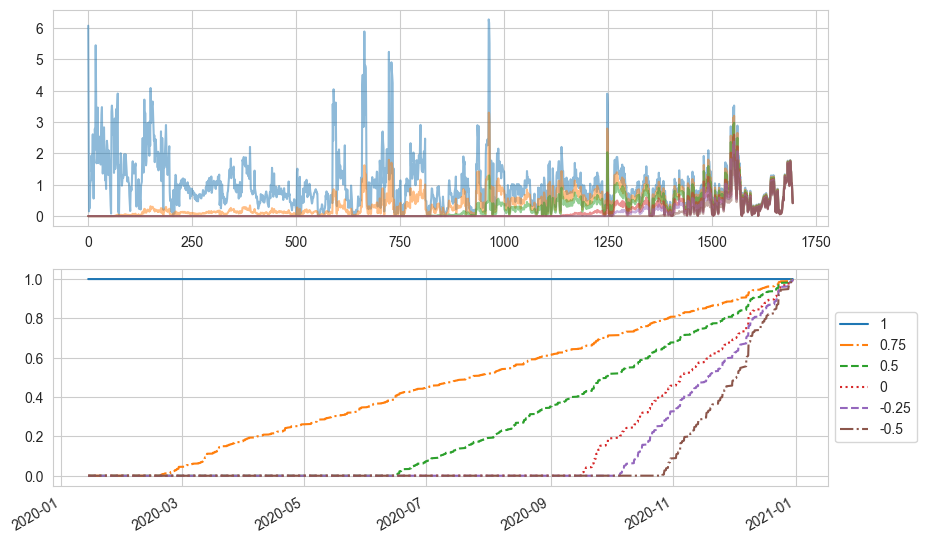

In [22]:
def getExTimeDecay(tW, clfLastW = 1.,exponent = 1):
    clfW = tW.sort_index().cumsum()
    if clfLastW >= 0: slope = ((1.-clfLastW)/clfW.iloc[-1]) ** exponent
    else: slope = (1./((clfLastW + 1) * clfW.iloc[-1])) ** exponent
    const = 1.-slope * clfW.iloc[-1]
    clfW = const + slope * clfW
    clfW[clfW < 0] = 0
    print(round(const, 4), round(slope, 4))
    return clfW

f,ax=plt.subplots(2,figsize=(10,7))
fs = [1,.75,.5,0,-.25,-.5]
ls = ['-','-.','--',':','--','-.']
for lstW, l in zip(fs,ls):
    decayFactor = getExTimeDecay(out['tW'].dropna(),
                                 clfLastW = lstW,
                                 exponent = 0.75) # experiment by changing exponent
    ((out['w'].dropna()*decayFactor).reset_index(drop=True)
     .plot(ax=ax[0],alpha=0.5))
    s = (pd.Series(1,index = out['w'].dropna().index) * decayFactor)
    s.plot(ax=ax[1], ls=l, label=str(lstW))
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [23]:
s

2020-01-14 10:07:24.543000    0.000000
2020-01-14 12:45:06.922385    0.000000
2020-01-14 13:38:25.132622    0.000000
2020-01-14 14:15:43.733944    0.000000
2020-01-14 15:03:05.454000    0.000000
                                ...   
2020-12-29 09:41:48.158449    0.976808
2020-12-29 09:59:40.765154    0.981503
2020-12-30 09:49:47.581448    0.986729
2020-12-30 10:40:27.689538    0.993015
2020-12-30 14:39:51.784295    1.000000
Length: 1695, dtype: float64

In [24]:
feature_Mat = feature_Mat.join(out, how = 'left').join(target, how = 'left').dropna()
feature_Mat

,dollar,frac_diff_dollar,tW,w,dailyVol
2020-01-14 10:07:24.543000,1039.5,3.953802,0.274534,6.075020,0.020679
2020-01-14 12:45:06.922385,1029.0,1.986190,0.201988,3.058973,0.017649
2020-01-14 13:38:25.132622,1025.7,1.149100,0.168875,0.152506,0.016894
2020-01-14 14:15:43.733944,1029.4,8.990513,0.148318,0.829902,0.014728
2020-01-14 15:03:05.454000,1023.3,2.870100,0.133792,0.260385,0.014794
...,...,...,...,...,...
2020-12-29 09:41:48.158449,1498.5,11.454225,0.078333,1.437115,0.030657
2020-12-29 09:59:40.765154,1498.7,11.655103,0.084028,1.047958,0.030880
2020-12-30 09:49:47.581448,1515.1,6.712599,0.093519,1.043268,0.030726
2020-12-30 10:40:27.689538,1521.0,12.064350,0.112500,0.660743,0.030825


In [25]:
# feature_Mat['w'] = feature_Mat['w'] * s

RSI

In [26]:
# Compute RSI
def calculate_rsi(prices, window):
    deltas = prices.diff()
    up = deltas.clip(lower=0)
    down = deltas.clip(upper=0).abs()

    avg_gain = up.rolling(window=window).mean()
    avg_loss = down.rolling(window=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi


def get_rsi(data, window=14):
    df = data.copy(deep=True).reset_index()
    rsi = calculate_rsi(df['dollar'], window)
    rsi_df = pd.Series(data=rsi.values, index=data.index)
    return rsi_df

In [27]:
data = feature_Mat.copy()
rsi_windows = [5, 13, 35]
for w in rsi_windows:
    rsi = get_rsi(data, window = w).squeeze()
    data[f'rsi_{w}'] = rsi

In [28]:
data

,dollar,frac_diff_dollar,tW,w,dailyVol,rsi_5,rsi_13,rsi_35
2020-01-14 10:07:24.543000,1039.5,3.953802,0.274534,6.075020,0.020679,NaN,NaN,NaN
2020-01-14 12:45:06.922385,1029.0,1.986190,0.201988,3.058973,0.017649,NaN,NaN,NaN
2020-01-14 13:38:25.132622,1025.7,1.149100,0.168875,0.152506,0.016894,NaN,NaN,NaN
2020-01-14 14:15:43.733944,1029.4,8.990513,0.148318,0.829902,0.014728,NaN,NaN,NaN
2020-01-14 15:03:05.454000,1023.3,2.870100,0.133792,0.260385,0.014794,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2020-12-29 09:41:48.158449,1498.5,11.454225,0.078333,1.437115,0.030657,83.204134,72.849462,63.641686
2020-12-29 09:59:40.765154,1498.7,11.655103,0.084028,1.047958,0.030880,90.756303,78.840580,67.346939
2020-12-30 09:49:47.581448,1515.1,6.712599,0.093519,1.043268,0.030726,100.000000,85.404101,70.337079
2020-12-30 10:40:27.689538,1521.0,12.064350,0.112500,0.660743,0.030825,100.000000,85.714286,69.982945


autocorr

In [29]:
data['log_ret'] = np.log(data['dollar']).diff()

window_autocorr = 50
data['autocorr_1'] = (data['log_ret']
                          .rolling(window=window_autocorr,
                                   min_periods=window_autocorr, center=False)
                          .apply(lambda x: x.autocorr(lag=1), raw=False))

data['autocorr_3'] = (data['log_ret']
                          .rolling(window=window_autocorr,
                                   min_periods=window_autocorr, center=False)
                          .apply(lambda x: x.autocorr(lag=3), raw=False))

data['autocorr_5'] = (data['log_ret']
                          .rolling(window=window_autocorr,
                                   min_periods=window_autocorr, center=False)
                          .apply(lambda x: x.autocorr(lag=5), raw=False))

In [30]:
data

,dollar,frac_diff_dollar,tW,w,dailyVol,rsi_5,rsi_13,rsi_35,log_ret,autocorr_1,autocorr_3,autocorr_5
2020-01-14 10:07:24.543000,1039.5,3.953802,0.274534,6.075020,0.020679,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-14 12:45:06.922385,1029.0,1.986190,0.201988,3.058973,0.017649,NaN,NaN,NaN,-0.010152,NaN,NaN,NaN
2020-01-14 13:38:25.132622,1025.7,1.149100,0.168875,0.152506,0.016894,NaN,NaN,NaN,-0.003212,NaN,NaN,NaN
2020-01-14 14:15:43.733944,1029.4,8.990513,0.148318,0.829902,0.014728,NaN,NaN,NaN,0.003601,NaN,NaN,NaN
2020-01-14 15:03:05.454000,1023.3,2.870100,0.133792,0.260385,0.014794,NaN,NaN,NaN,-0.005943,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-29 09:41:48.158449,1498.5,11.454225,0.078333,1.437115,0.030657,83.204134,72.849462,63.641686,0.011072,-0.029216,-0.069095,0.082742
2020-12-29 09:59:40.765154,1498.7,11.655103,0.084028,1.047958,0.030880,90.756303,78.840580,67.346939,0.000133,-0.034480,-0.060300,0.090491
2020-12-30 09:49:47.581448,1515.1,6.712599,0.093519,1.043268,0.030726,100.000000,85.404101,70.337079,0.010883,-0.044398,-0.042078,0.063126
2020-12-30 10:40:27.689538,1521.0,12.064350,0.112500,0.660743,0.030825,100.000000,85.714286,69.982945,0.003887,-0.002598,0.003074,0.100994


labeling

In [31]:
labels = fml.getBins(events, feature_Mat.dollar)
clean_labels = fml.dropLabels(labels, 0.05)
clean_labels

dropped label 0.0 0.001183431952662722


,ret,bin
2020-01-14 10:07:24.543000,-0.002020,-1.0
2020-01-14 12:45:06.922385,0.008163,1.0
2020-01-14 13:38:25.132622,0.011407,1.0
2020-01-14 14:15:43.733944,0.007772,1.0
2020-01-14 15:03:05.454000,0.013779,1.0
...,...,...
2020-12-28 12:00:32.207305,0.032727,1.0
2020-12-28 13:47:26.483838,0.030961,1.0
2020-12-28 13:54:22.938882,0.033281,1.0
2020-12-28 15:32:54.716750,0.034506,1.0


feature matrix

In [32]:
from multiprocessing import Pool
import test

if __name__ == "__main__":
    with Pool() as pool:
        seqUs = test.main_mp(t1)
        #result = pool.map(test.main_mp(t1), range(10))
        #print(result)

023-06-25 03:45:15.673711 7.0% mp_func done after 0.17 minutes. Remaining 2.31 minutes.2023-06-25 03:45:15.930591 10.0% mp_func done after 0.18 minutes. Remaining 1.6 minutes.2023-06-25 03:45:16.229146 17.0% mp_func done after 0.18 minutes. Remaining 0.89 minutes.2023-06-25 03:45:16.509163 23.0% mp_func done after 0.19 minutes. Remaining 0.63 minutes.2023-06-25 03:45:16.735486 25.0% mp_func done after 0.19 minutes. Remaining 0.57 minutes.2023-06-25 03:45:16.962691 32.0% mp_func done after 0.2 minutes. Remaining 0.41 minutes.2023-06-25 03:45:17.181969 34.0% mp_func done after 0.2 minutes. Remaining 0.39 minutes.2023-06-25 03:45:17.546537 41.0% mp_func done after 0.2 minutes. Remaining 0.29 minutes.2023-06-25 03:45:17.882656 48.0% mp_func done after 0.21 minutes. Remaining 0.23 minutes.2023-06-25 03:45:18.166053 51.0% mp_func done after 0.22 minutes. Remaining 0.21 minutes.2023-06-25 03:45:18.461972 57.0% mp_func done after 0.22 minutes. Remaining 0.17 minutes.2023-06-25 03:45:18.685397 

In [33]:
avg_uniqueness = seqUs.mean()[0]
avgU1 = out['tW'].mean()

#### Primary Model

In [34]:
target = clean_labels.bin
target

2020-01-14 10:07:24.543000   -1.0
2020-01-14 12:45:06.922385    1.0
2020-01-14 13:38:25.132622    1.0
2020-01-14 14:15:43.733944    1.0
2020-01-14 15:03:05.454000    1.0
                             ... 
2020-12-28 12:00:32.207305    1.0
2020-12-28 13:47:26.483838    1.0
2020-12-28 13:54:22.938882    1.0
2020-12-28 15:32:54.716750    1.0
2020-12-28 15:45:00.000000    1.0
Name: bin, Length: 1688, dtype: float64

In [35]:
data = data.join(target, how = 'left').dropna()
data

,dollar,frac_diff_dollar,tW,w,dailyVol,rsi_5,rsi_13,rsi_35,log_ret,autocorr_1,autocorr_3,autocorr_5,bin
2020-02-10 13:56:19.128522,1008.4,1.132961,0.127734,2.012902,0.029122,69.329073,74.942263,46.507666,0.007465,0.015892,-0.195284,0.029498,1.0
2020-02-10 14:27:13.844769,1012.5,7.689144,0.131200,1.540604,0.028662,69.032258,71.854734,47.947524,0.004058,0.018027,-0.219304,0.037405,1.0
2020-02-11 13:34:23.354807,1018.7,2.775017,0.132086,1.219721,0.028802,64.963504,75.121951,49.502900,0.006105,0.028183,-0.220265,0.062809,1.0
2020-02-12 12:50:20.792144,1028.4,9.512627,0.135582,0.790584,0.028690,92.905405,74.274905,58.647299,0.009477,0.049515,-0.196871,0.051995,-1.0
2020-02-12 15:45:00.000000,1025.9,2.961943,0.142526,0.338952,0.028100,91.666667,73.533084,59.842520,-0.002434,0.044040,-0.187437,0.069036,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-28 12:00:32.207305,1472.8,4.874438,0.056442,1.262867,0.031266,76.170213,70.666667,44.486692,0.000951,-0.097505,-0.073632,0.108348,1.0
2020-12-28 13:47:26.483838,1469.6,11.138082,0.052992,0.994696,0.030855,61.233480,65.871560,52.668810,-0.002175,-0.101154,-0.075773,0.095123,1.0
2020-12-28 13:54:22.938882,1466.3,4.696408,0.054248,1.057246,0.030352,13.571429,63.992870,51.802657,-0.002248,-0.096853,-0.072469,0.074389,1.0
2020-12-28 15:32:54.716750,1478.0,11.672417,0.071499,1.789101,0.030272,67.661692,65.935919,58.028518,0.007948,-0.111513,-0.065003,0.043565,1.0


### Secondary Model
use Primary Model Prediction

In [36]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [37]:
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False)

#### RandomForest Classifier

In [38]:
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier
from scipy import interp

rf = RandomForestClassifier(n_estimators = 1000, criterion = "entropy", bootstrap = True,
                                n_jobs=1, random_state = 42, class_weight = 'balanced_subsample', oob_score = False)

cv_gen0 = KFold(n_splits = 5, shuffle = False)

score = fml.cvScore(rf, X_train, y_train, sample_weight = X_train['w'], scoring = 'neg_log_loss', cv = None, cvGen = cv_gen0, pctEmbargo = 0.1)
print('rf_clf Mean CV score: {0:.6f}\nCV Variance: {1:.6f}'.format(score.mean(), score.var()))

rf_clf Mean CV score: -0.992159
CV Variance: 0.112214


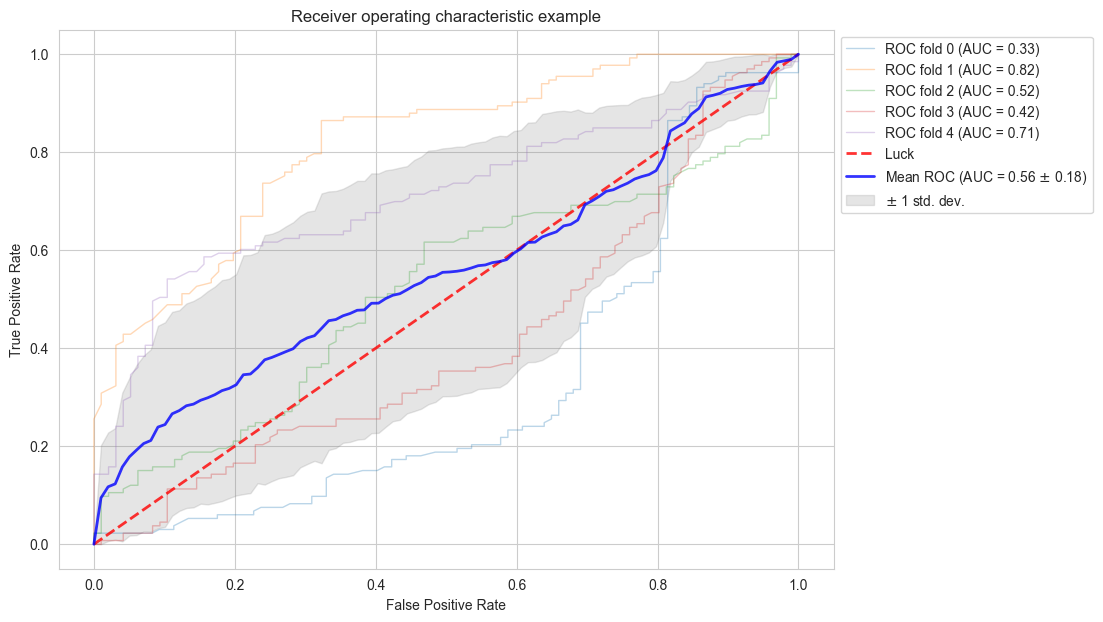

In [39]:
skf = StratifiedKFold(n_splits = 5, shuffle = False)
classifier = RandomForestClassifier(n_estimators = 1000, criterion = 'entropy', bootstrap = True,
                                    class_weight = 'balanced_subsample', random_state = 42, oob_score = False)
fml.crossValPlot(skf, classifier, X_train, y_train)

              precision    recall  f1-score   support

    no trade       0.27      0.37      0.31       148
       trade       0.68      0.57      0.62       344

    accuracy                           0.51       492
   macro avg       0.47      0.47      0.47       492
weighted avg       0.56      0.51      0.53       492



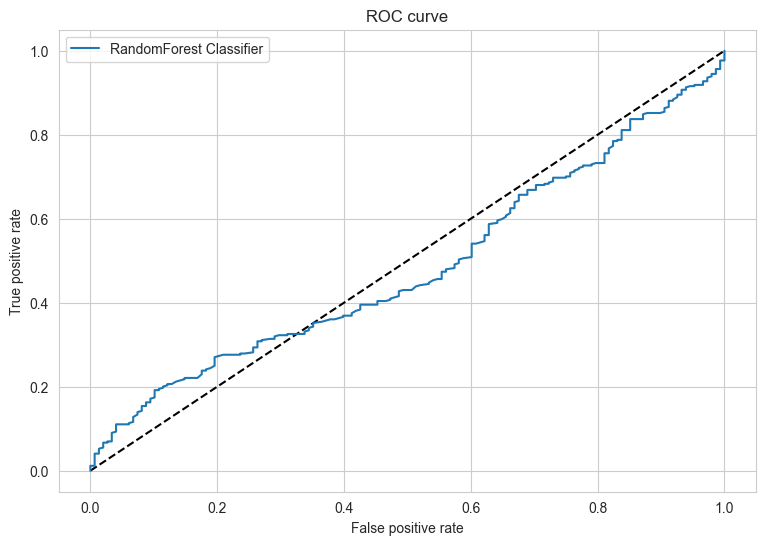

In [40]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

fit = rf.fit(X_train, y_train)

y_pred_rf = fit.predict_proba(X_test)[:, 1]
y_pred = fit.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred, target_names = ['no trade',' trade']))

plt.figure(figsize = (9,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label = 'RandomForest Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Feature Importance

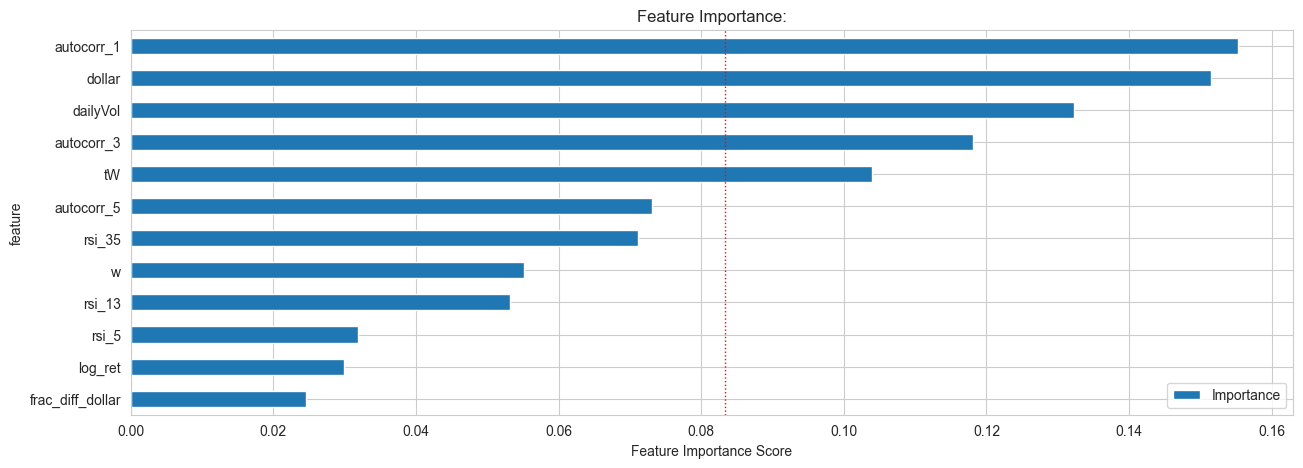

In [41]:
title = 'Feature Importance:'
figsize = (15, 5)

feat_imp = pd.DataFrame({'Importance':rf.feature_importances_})
feat_imp['feature'] = X.columns
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
feat_imp = feat_imp

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title=title, figsize=figsize)
plt.axvline(1. / feat_imp.shape[0], linewidth = 1, color='r', linestyle='dotted')
plt.xlabel('Feature Importance Score')
plt.show()

#### DecisionTree & Bagging Classifier

In [42]:
n_estimator = 1000
dt = DecisionTreeClassifier(criterion = 'entropy', max_features = 'auto', class_weight = 'balanced')
bc = BaggingClassifier(base_estimator = dt, n_estimators = n_estimator,
                       max_samples = avgU1, max_features = 1., random_state = 42)

In [43]:
cv_gen0 = KFold(n_splits = 5, shuffle = False)

score = fml.cvScore(bc, X_train, y_train, sample_weight = X_train['w'], scoring = 'neg_log_loss', cv = None, cvGen = cv_gen0, pctEmbargo = 0.1)
print('rf_clf Mean CV score: {0:.6f}\nCV Variance: {1:.6f}'.format(score.mean(), score.var()))

rf_clf Mean CV score: -0.771734
CV Variance: 0.026927


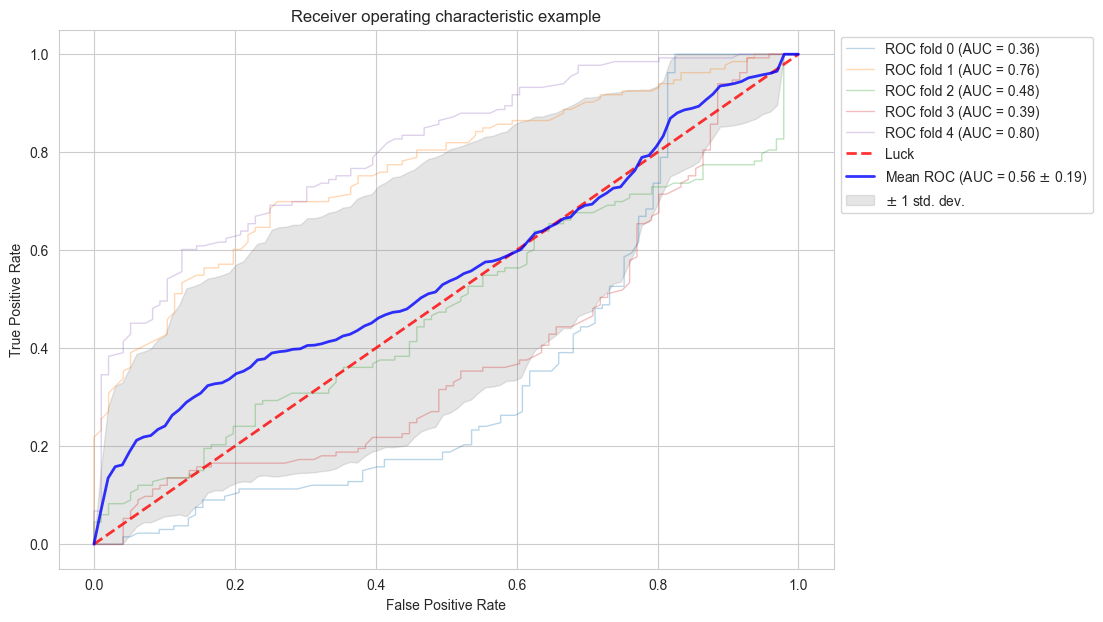

In [44]:
skf = StratifiedKFold(n_splits = 5, shuffle = False)
classifier = BaggingClassifier(base_estimator = dt, n_estimators = n_estimator,
                               max_samples = avgU1, max_features = 1., random_state = 42)
fml.crossValPlot(skf, classifier, X_train, y_train)

              precision    recall  f1-score   support

    no trade       0.27      0.37      0.31       148
       trade       0.68      0.57      0.62       344

    accuracy                           0.51       492
   macro avg       0.47      0.47      0.47       492
weighted avg       0.56      0.51      0.53       492



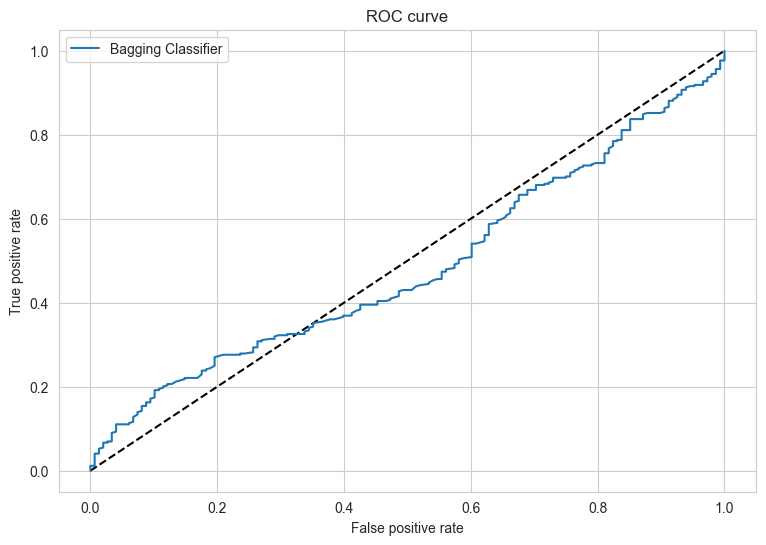

In [45]:
y_pred_bc = fit.predict_proba(X_test)[:, 1]
y_pred = fit.predict(X_test)
fpr_bc, tpr_bc, _ = roc_curve(y_test, y_pred_bc)
print(classification_report(y_test, y_pred, target_names = ['no trade',' trade']))

plt.figure(figsize = (9,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_bc, tpr_bc, label = 'Bagging Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

#### RandomForest & Bagging Classifier

In [46]:
n_estimator = 1000
rf2 = RandomForestClassifier(n_estimators = 1, criterion = 'entropy', bootstrap = False, class_weight = 'balanced_subsample')
bc2 = BaggingClassifier(base_estimator = rf2, n_estimators = n_estimator,
                        max_samples = avgU1, max_features = 1., random_state = 42)

fit = bc2.fit(X_train, y_train)

In [47]:
cv_gen0 = KFold(n_splits = 5, shuffle = False)

score = fml.cvScore(bc2, X_train, y_train, sample_weight = X_train['w'], scoring = 'neg_log_loss', cv = None, cvGen = cv_gen0, pctEmbargo = 0.1)
print('rf_clf Mean CV score: {0:.6f}\nCV Variance: {1:.6f}'.format(score.mean(), score.var()))

rf_clf Mean CV score: -0.777236
CV Variance: 0.027261


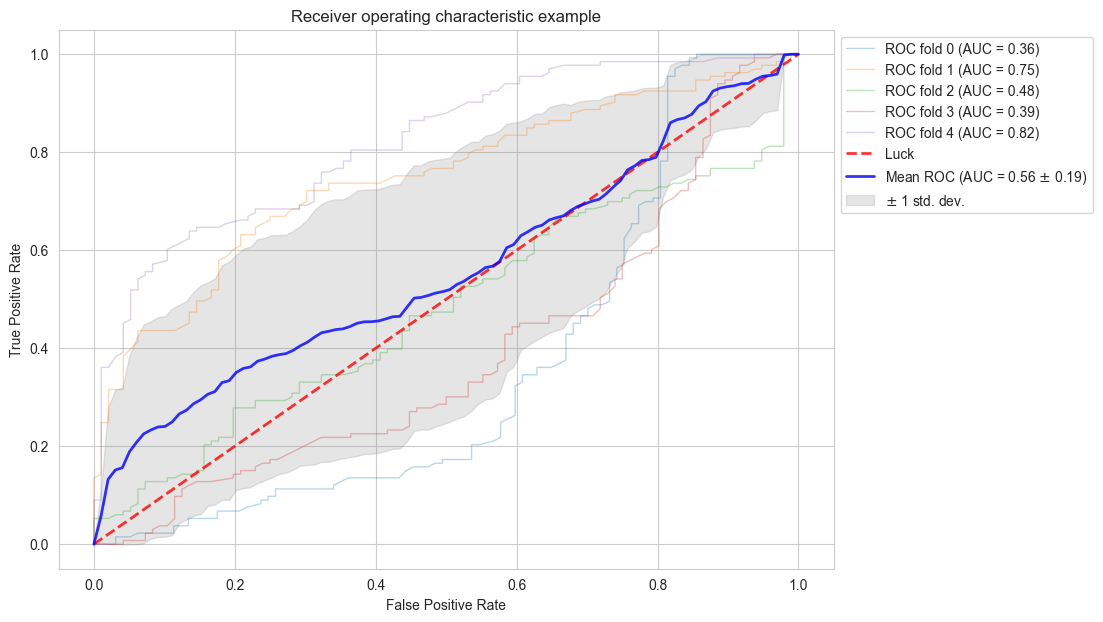

In [48]:
skf = StratifiedKFold(n_splits = 5, shuffle = False)
classifier = BaggingClassifier(base_estimator = rf2, n_estimators = n_estimator,
                               max_samples = avgU1, max_features = 1., random_state = 42)
fml.crossValPlot(skf, classifier, X_train, y_train)

              precision    recall  f1-score   support

    no trade       0.28      0.21      0.24       148
       trade       0.69      0.77      0.73       344

    accuracy                           0.60       492
   macro avg       0.49      0.49      0.48       492
weighted avg       0.57      0.60      0.58       492



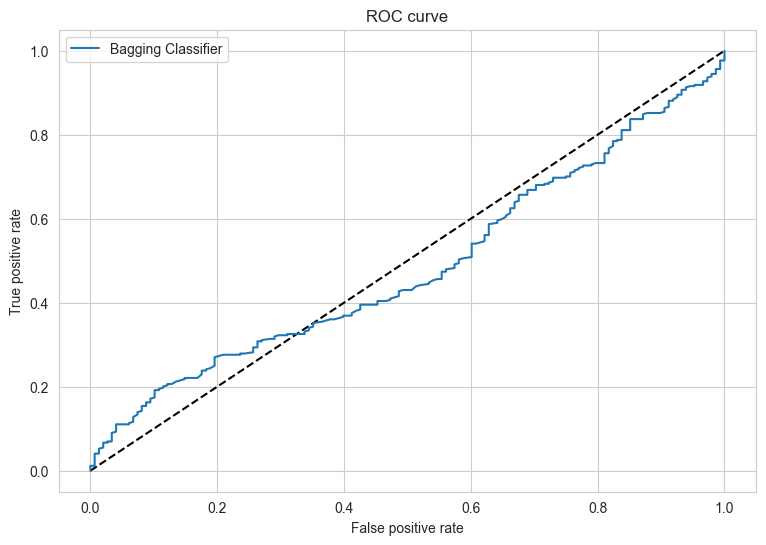

In [49]:
y_pred_bc2 = fit.predict_proba(X_test)[:, 1]
y_pred = fit.predict(X_test)
fpr_bc, tpr_bc, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred, target_names = ['no trade',' trade']))

plt.figure(figsize = (9,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_bc, tpr_bc, label = 'Bagging Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [50]:
yprf = pd.Series(y_pred_rf, index = X_test.index)
ytest = pd.Series(y_test, index = X_test.index)

In [58]:
yt = pd.DataFrame(yprf)
yt = pd.concat([yt, X_test['log_ret']], axis = 1)
yt = pd.concat([yt, ytest], axis = 1)
z = (yt[0] - 1 / 2) / (yt[0] * (1 - yt[0])) ** 0.5
cali_pred = (yprf - yprf.min()) / (yprf.max() - yprf.min())
yt = pd.concat([yt, z], axis = 1)
yt = pd.concat([yt, z * X_test['log_ret'] * 10], axis = 1)
yt = pd.concat([yt, cali_pred], axis = 1)
yt.columns = ['pred_prob','log_ret','bin','bet_size','profit','cali_pred']
print(yt)

                            pred_prob   log_ret  bin  bet_size    profit  \
2020-09-23 12:36:33.789724      0.545  0.007431 -1.0  0.090367  0.006715   
2020-09-23 12:49:26.634108      0.529  0.005363 -1.0  0.058098  0.003116   
2020-09-23 12:59:20.355107      0.500  0.000310 -1.0  0.000000  0.000000   
2020-09-23 13:03:59.648213      0.531  0.003867 -1.0  0.062120  0.002402   
2020-09-23 13:18:30.758345      0.488 -0.000849 -1.0 -0.024007  0.000204   
...                               ...       ...  ...       ...       ...   
2020-12-28 12:00:32.207305      0.597  0.000951  1.0  0.197757  0.001881   
2020-12-28 13:47:26.483838      0.592 -0.002175  1.0  0.187196 -0.004072   
2020-12-28 13:54:22.938882      0.600 -0.002248  1.0  0.204124 -0.004589   
2020-12-28 15:32:54.716750      0.626  0.007948  1.0  0.260404  0.020696   
2020-12-28 15:45:00.000000      0.671  0.002703  1.0  0.363946  0.009836   

                            cali_pred  
2020-09-23 12:36:33.789724   0.551136  
2020-09

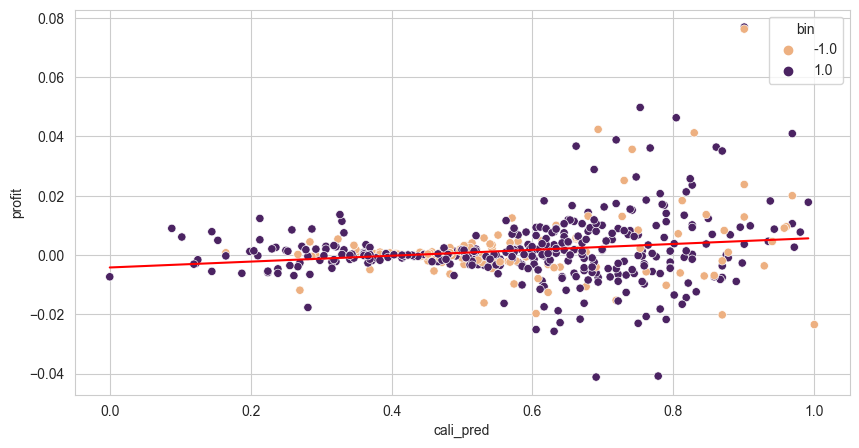

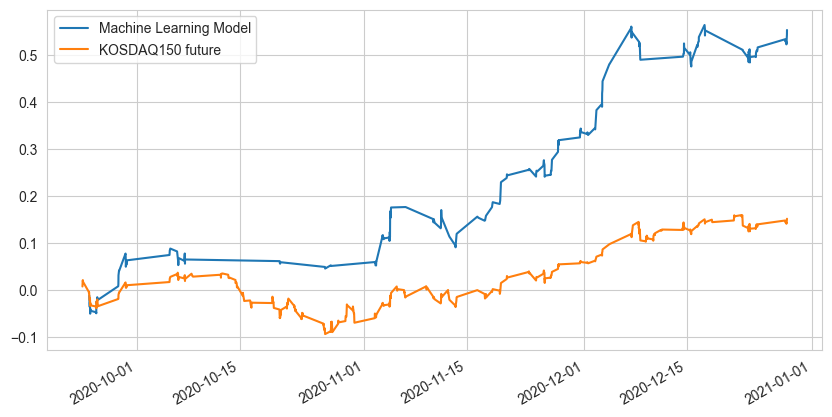

In [59]:
fig, ax = plt.subplots(figsize=(10, 5))

coefficients = np.polyfit(yt['cali_pred'][yt['bin'] == 1.0], yt['profit'][yt['bin'] == 1.0], 1)
regression_line = np.poly1d(coefficients)
x_range = np.linspace(np.min(yt['cali_pred'][yt['bin'] == 1.0]), np.max(yt['cali_pred'][yt['bin'] == 1.0]), 100)
y_range = regression_line(x_range)
ax.plot(x_range, y_range, color='red')

sns.scatterplot(data = yt, x = 'cali_pred', y="profit", hue='bin', palette='flare', ax=ax)
plt.show()

yt['profit'][yt['bin'] == 1][yt['cali_pred'] >= 0.5].cumsum().plot(label = 'Machine Learning Model', figsize = (10,5))
yt['log_ret'].cumsum().plot(label = 'KOSDAQ150 future')
plt.legend()

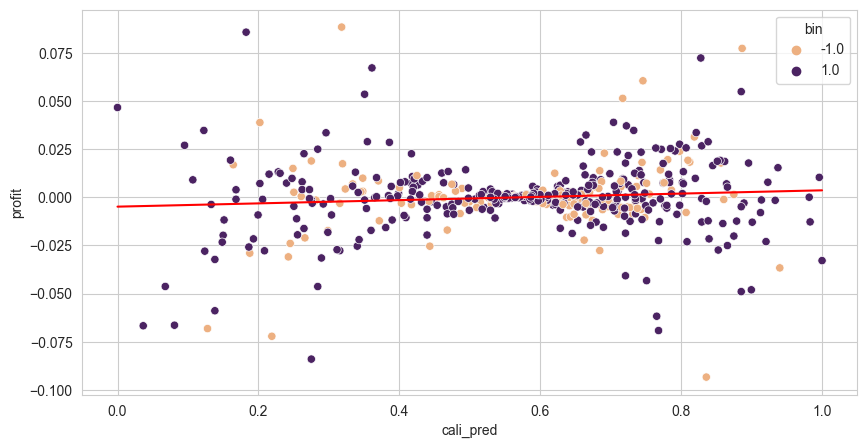

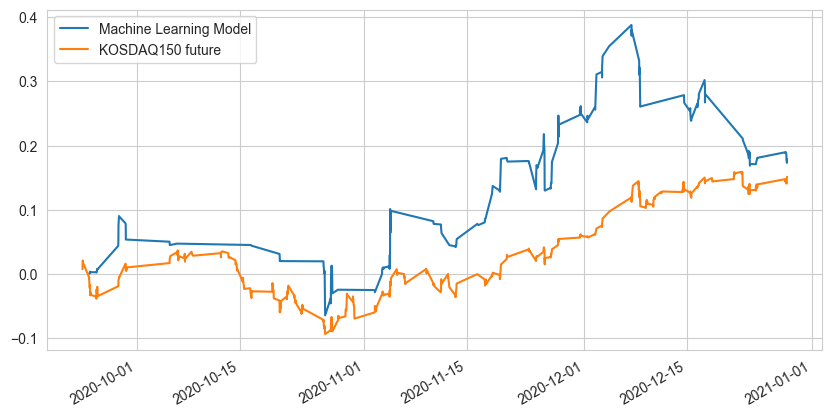

In [62]:
yprf = pd.Series(y_pred_bc, index = X_test.index)
ytest = pd.Series(y_test, index = X_test.index)
yt = pd.DataFrame(yprf)
yt = pd.concat([yt, X_test['log_ret']], axis = 1)
yt = pd.concat([yt, ytest], axis = 1)
z = (yt[0] - 1 / 2) / (yt[0] * (1 - yt[0])) ** 0.5
cali_pred = (yprf - yprf.min()) / (yprf.max() - yprf.min())
yt = pd.concat([yt, z], axis = 1)
yt = pd.concat([yt, z * X_test['log_ret'] * 10], axis = 1)
yt = pd.concat([yt, cali_pred], axis = 1)
yt.columns = ['pred_prob','log_ret','bin','bet_size','profit','cali_pred']

fig, ax = plt.subplots(figsize=(10, 5))

coefficients = np.polyfit(yt['cali_pred'][yt['bin'] == 1.0], yt['profit'][yt['bin'] == 1.0], 1)
regression_line = np.poly1d(coefficients)
x_range = np.linspace(np.min(yt['cali_pred'][yt['bin'] == 1.0]), np.max(yt['cali_pred'][yt['bin'] == 1.0]), 100)
y_range = regression_line(x_range)
ax.plot(x_range, y_range, color='red')

sns.scatterplot(data=yt, x='cali_pred', y="profit", hue='bin', palette='flare', ax=ax)
plt.show()

yt['profit'][yt['bin'] == 1][yt['cali_pred'] >= 0.5].cumsum().plot(label='Machine Learning Model', figsize=(10, 5))
yt['log_ret'].cumsum().plot(label='KOSDAQ150 future')
plt.legend()

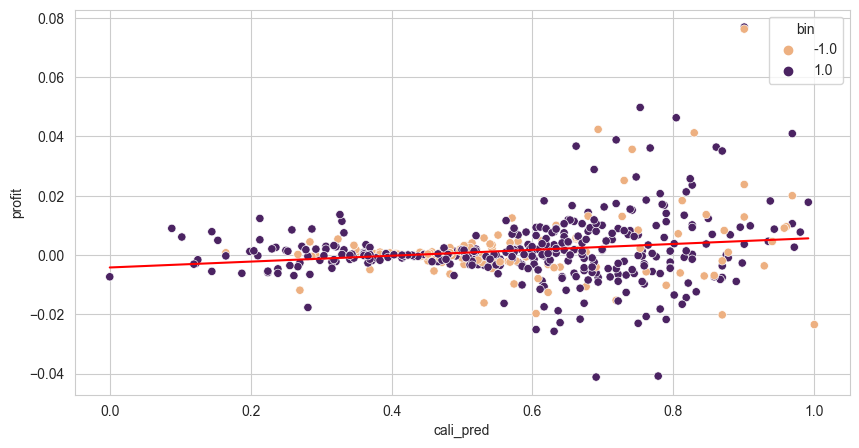

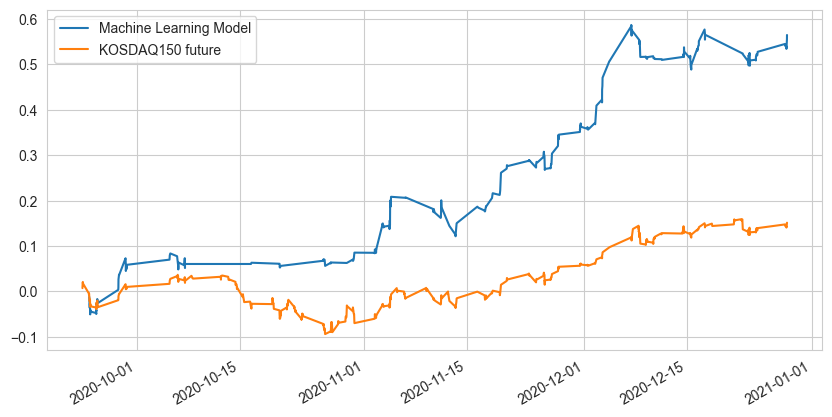

In [63]:
yprf = pd.Series(y_pred_bc2, index = X_test.index)
ytest = pd.Series(y_test, index = X_test.index)
yt = pd.DataFrame(yprf)
yt = pd.concat([yt, X_test['log_ret']], axis = 1)
yt = pd.concat([yt, ytest], axis = 1)
z = (yt[0] - 1 / 2) / (yt[0] * (1 - yt[0])) ** 0.5
cali_pred = (yprf - yprf.min()) / (yprf.max() - yprf.min())
yt = pd.concat([yt, z], axis = 1)
yt = pd.concat([yt, z * X_test['log_ret'] * 10], axis = 1)
yt = pd.concat([yt, cali_pred], axis = 1)
yt.columns = ['pred_prob','log_ret','bin','bet_size','profit','cali_pred']

fig, ax = plt.subplots(figsize=(10, 5))

coefficients = np.polyfit(yt['cali_pred'][yt['bin'] == 1.0], yt['profit'][yt['bin'] == 1.0], 1)
regression_line = np.poly1d(coefficients)
x_range = np.linspace(np.min(yt['cali_pred'][yt['bin'] == 1.0]), np.max(yt['cali_pred'][yt['bin'] == 1.0]), 100)
y_range = regression_line(x_range)
ax.plot(x_range, y_range, color='red')

sns.scatterplot(data=yt, x='cali_pred', y="profit", hue='bin', palette='flare', ax=ax)
plt.show()

yt['profit'][yt['bin'] == 1][yt['cali_pred'] >= 0.3].cumsum().plot(label='Machine Learning Model', figsize=(10, 5))
yt['log_ret'].cumsum().plot(label='KOSDAQ150 future')
plt.legend()